# Binary Classifier w/ Embedding


This Notebook builds on from the previous example. It will show how to include an embedding layer.

---
#### Introduction
Embeddings are an important concept in modern deep learning. Especially for tabular data and NLP style applications. They are basically high dimensional spaces in which the model tries to position the feature *values* so their relative distance is useful for solving the problem at hand.

That sounds very abstract. But it turns out that by asking the model to position the values of a feature in a multi-dimensional space, some of the axis in this space convey a 'meaning'/'aspect' of the feature. 

There's a lot of good examples online. One simple and interesting example is an NLP one, where a model is asked to predict the words around a given word. If you plot countries and capitals of that embedding and reduce along a certain set of axis you get a picture like below where the countries are on one side, and the capitals on another side. Moreover there is a very similar vector going from country to capital. This vector can be thought of as a __transformation__ from country to capital. The model learnt this relationship through positioning of the words in the space and can use it to solve problems.

For instance if we were to ask it what the capital of 'England' is, it might use this transformation and find that 'London' is a good candidate. 

Obviously for real life problems these spaces can have hundreds of dimensions, giving the model the ability to capture a large number of these 'aspects' of words.

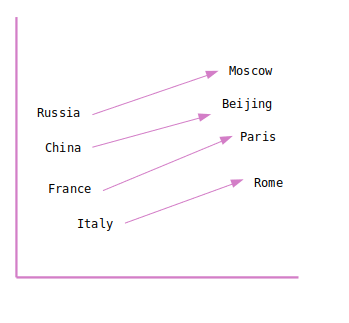

#### Embedding Layer output
People who are not all that familiar with embeddings might not immediately see what they output, we'll present an example here.

In the example data we have a feature __'category'__, this features holds the category of the Merchant, for instance 'ES_Leisure', 'ES_Health' and 'ES_Transportation'.... Let's for argument sake plot them in a 2-D embedding. They might look like below. Each value of the 'category' feature can be thought of as a vector with coordinates. In our example *(2,3)* for ES_Health.

When we feed in ES_Health into the 'category' Embedding, the layer will return the coordinates of the ES_Health vector *(2,3)* i.e. a vector with 2 numbers because we are in __2-D space__. If we feed in ES_Transportation we'll get *(3,1)* as output. If we would have set-up a 3-D space, we'd be getting a vector with 3 coordinates.

Because we feed back the coordinates, the model can __'learn'__ and change the coordinates as we train it, thus re-position the elements in our space. During training it might for instance nudge ES_Health to *(2.2, 2.9)* if that reduces the loss.

Last but not least; we do not actually feed 'ES_Leisure' to an Embedding, Embeddings require __'Long/Integer'__ as input, so the input has to be indexed, we'll need to convert the data so that for instance '1' is ES_Leisure, '2' is ES_Health and '3' is ES_Transportation. 1, 2 and 3 is what we provide as input to the Embedding layer, *(0.5, 1.2), (2, 3)* and *(3, 1)* is what we get back.

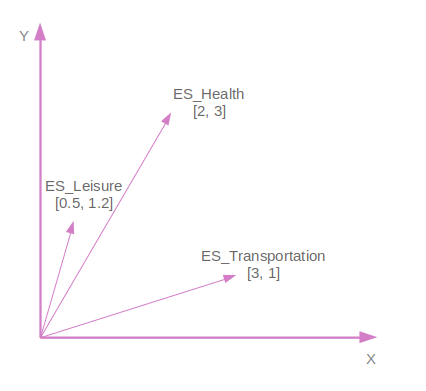

#### Note on the data set 
The data set used here is not particulary complex and/or big. It's not really all that challenging to find the fraud. In an ideal world we'd be using more complex data sets to show the real power of Deep Learning. There are a bunch of PCA'ed data sets available, but the PCA obfuscates some of the elements that are useful. 
*These examples are meant to show the possibilities, it's not so useful to interpret their performance on this data set*

## Imports

In [1]:
import torch
import numpy as np
import gc

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl

## Set a random seed for Numpy and Torch
> Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Define Base and derived features.
> In order to get the model to use embeddings we will define features of type `FeatureIndex` rather than `FeatureOneHot` (from the previous example). Index features will 'index' a string or categorical variable. They will for instance turn ['FR', 'FR', 'GB', 'DE', 'GB'] into [1, 1, 2, 3, 2]. Where each country now has its own unique number.

> Note how in the output we see has less columns. The values for the index are no longer binary 0 and 1 like for the one-hot features.

In [3]:
# Change this to read from another location
file = '../../../../data/bs140513_032310.csv'

In [4]:
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

amount_scale = ft.FeatureNormalizeScale('amount_scale', ft.FEATURE_TYPE_FLOAT_32, amount)

# Define Index Features. This part is different from the previous example
age_i = ft.FeatureIndex('age_index', ft.FEATURE_TYPE_INT_8, age)
gender_i = ft.FeatureIndex('gender_index', ft.FEATURE_TYPE_INT_8, gender)
merchant_i = ft.FeatureIndex('merchant_index', ft.FEATURE_TYPE_INT_16, merchant)
category_i = ft.FeatureIndex('category_index', ft.FEATURE_TYPE_INT_16, category)
# End of difference

fraud_label = ft.FeatureLabelBinary('fraud_label', ft.FEATURE_TYPE_INT_8, fraud)

features = ft.TensorDefinition(
    'learning', 
    [
        age_i,
        gender_i,
        merchant_i,
        category_i,
        amount_scale
    ])

label = ft.TensorDefinition('label', [fraud_label])

model_features = ft.TensorDefinitionMulti([features, label])

with en.EnginePandasNumpy() as e:
    ft = e.from_csv(features, file, inference=False)
    lb = e.from_csv(label, file, inference=False)

ft

2021-09-15 15:13:41.013 d373c7.engines.common          INFO     Start Engine...
2021-09-15 15:13:41.014 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2021-09-15 15:13:41.014 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2021-09-15 15:13:41.014 d373c7.engines.panda_numpy     INFO     Building Panda for : learning from file ../../../../data/bs140513_032310.csv
2021-09-15 15:13:41.180 d373c7.engines.panda_numpy     INFO     Building Panda for : <Source_Derive_Source> from DataFrame. Inference mode <False>
2021-09-15 15:13:41.180 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Source_Derive_Source
2021-09-15 15:13:41.182 d373c7.engines.panda_numpy     INFO     Done creating Source_Derive_Source. Shape=(594643, 5)
2021-09-15 15:13:41.184 d373c7.engines.panda_numpy     INFO     Create amount_scale Normalize/Scale amount. Min. 0.00 Max. 8329.96
2021-09-15 15:13:41.206 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: learning
202

,age_index,gender_index,merchant_index,category_index,amount_scale
0,1,1,1,1,0.000546
1,2,1,1,1,0.004764
2,1,2,2,1,0.003228
3,3,1,1,1,0.002071
4,4,1,1,1,0.004288
...,...,...,...,...,...
594638,3,2,2,1,0.002465
594639,1,2,2,1,0.006090
594640,2,2,15,11,0.002694
594641,4,1,2,1,0.001736


## Convert to Numpy
After converting the panda DataFrame to numpy lists per learning type, we have a first list with 1 continous feature (the amount), a second with 4 categorical features (the `FeatureIndex` features) and the last list contains the label

In [5]:
with en.EnginePandasNumpy() as e:
    ft_np = e.to_numpy_list(features, ft)
    lb_np = e.to_numpy_list(label, lb)

data_list = en.NumpyList(ft_np.lists + lb_np.lists)

print(data_list.shapes)
print(data_list.dtype_names)

2021-09-15 15:13:43.087 d373c7.engines.common          INFO     Start Engine...
2021-09-15 15:13:43.088 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2021-09-15 15:13:43.088 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2021-09-15 15:13:43.089 d373c7.engines.panda_numpy     INFO     Converting DataFrame to Numpy of type: float32
2021-09-15 15:13:43.089 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Continuous
2021-09-15 15:13:43.092 d373c7.engines.panda_numpy     INFO     Converting DataFrame to Numpy of type: int16
2021-09-15 15:13:43.092 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Categorical
2021-09-15 15:13:43.094 d373c7.engines.panda_numpy     INFO     Converting DataFrame to Numpy of type: int8
2021-09-15 15:13:43.094 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Label


[(594643,), (594643, 4), (594643,)]
['float32', 'int16', 'int8']


## Wrangle the data
Time split the data. For time series data it is very important to keep the order of the data. This split will start from the end and work it's way to the front of the data. This way the training, validation and test data are nicely colocated in time

> 1. Split out a test-set of size `test_records`. This is used for model testing.
> 2. Split out a validation-set of size `validation_records`. It will be used to monitor overfitting during training
> 3. All the rest is considered training data.

__Important__; please make sure the data is ordered in ascending fashion on a date(time) field. The split function does not order the data, it assumes the data is in the correct order.

In [6]:
test_records = 100000
val_records  = 30000 

train_data, val_data, test_data = data_list.split_time(val_records, test_records) 

print(f'Training Data shapes {train_data.shapes}')
print(f'Validation Data shapes {val_data.shapes}')
print(f'Test Data shapes {test_data.shapes}')
del ft, lb
del ft_np, lb_np
del data_list

gc.collect()
print('Done')

Training Data shapes [(464643,), (464643, 4), (464643,)]
Validation Data shapes [(30000,), (30000, 4), (30000,)]
Test Data shapes [(100000,), (100000, 4), (100000,)]
Done


## Setup the Devices

In [7]:
device, cpu = pt.init_devices()

2021-09-15 15:13:46.113 d373c7.pytorch.common          INFO     Torch Version : 1.9.0+cu111
2021-09-15 15:13:46.175 d373c7.pytorch.common          INFO     GPU found. Using GPU <0>
2021-09-15 15:13:46.176 d373c7.pytorch.common          INFO     Cuda Version  : 11.1


# Define Model


The training data set has to be balanced for Neural Nets. To do this, the fraud class will be aggressively upsampled in the training phase by a custom `ClassSampler`. It oversamples the minority label until it matches the majority label. This may not be a good idea for a really large data sets.

> 1. First set-up a NumpyListDataSet for both the training data-set and validation data-set. A NumpyListDataSet is a specialised `Pytorch Dataset` which keeps the data as numpy arrays in memory and converts on the fly to `Pytorch Tensors`
> 2. Set-up a sampler for the training set only. The sampler will over-sample the '1'/fraud class. Note that this means the training and validation set are balanced *differently*. This is important when interpreting the plots.
> 3. Wrap the dataset in a Pytorch Dataloader. `Dataloaders` allow the training loop to iterate over 'batches' of the `Datasets`
> 4. Create a model. Here the most basic `GeneratedClassifier` is used. The GeneratedClassifier will create a model using the information it has about the features. *We are defining it to have 1 hidden layer of size 16*.  The last layer is a single number, it had a sigmoid applied to it so we can more or less interpret this as a 'probability of fraud'. We use Binary Crossentropy loss.


Note that even though we defined the model the same way, it's a different model now. The first layer no longer a linear layer. The first layer now has embeddings. One for each index feature. The `GeneratedClassifier` model does this because it saw that we have *Categorical/Index* features as input.

In [8]:
# Setup Pytorch Datasets for the training and validation
batch_size = 128
train_ds = pt.NumpyListDataSetMulti(model_features, train_data)
val_ds = pt.NumpyListDataSetMulti(model_features, val_data)
train_sampler = pt.ClassSamplerMulti(model_features, train_data).over_sampler()

# Wrap them in a Pytorch Dataloader
train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2, sampler=train_sampler)
val_dl = val_ds.data_loader(cpu, batch_size, num_workers=2)

# Create a Model
m = pm.GeneratedClassifier(model_features, linear_layers=[16])
print(m)

GeneratedClassifier(
  Number of parameters : 2164. Loss : SingleLabelBCELoss,  mean
  (streams): ModuleList(
    (0): TensorDefinitionHead(
      lcs=['Continuous', 'Categorical']
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(9, 4)
          (1): Embedding(5, 4)
          (2): Embedding(51, 25)
          (3): Embedding(16, 7)
        )
        (dropout): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (tail): TailBinary(
    (layers): Sequential(
      (tail_lin_01): Linear(in_features=41, out_features=16, bias=True)
      (tail_act_01): ReLU()
      (tail_dropout_01): Dropout(p=0.1, inplace=False)
      (tail_batch_norm): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (tail_binary): Linear(in_features=16, out_features=1, bias=True)
      (tail_bin_act): Sigmoid()
    )
  )
)


#### Graphically the embedding model looks more or less like below.
> Each of the 4 __categorical__ features is feed through an embedding. The embeddings have different dimensions depending on the cardinality of the feature. As output each embedding gives the coordinates of the value in the space. The number of coordinates is different for each embedding.

> Those coordinates are all concatenated into one big layer and the continuous features is also added on. From there on out the model is similar to the previous *FeedForward* model. The 41 features are fed to a Linear Linear layer with 16 output features and then further to 1 output feature

_*(Some layers have been omitted for simplicity)_

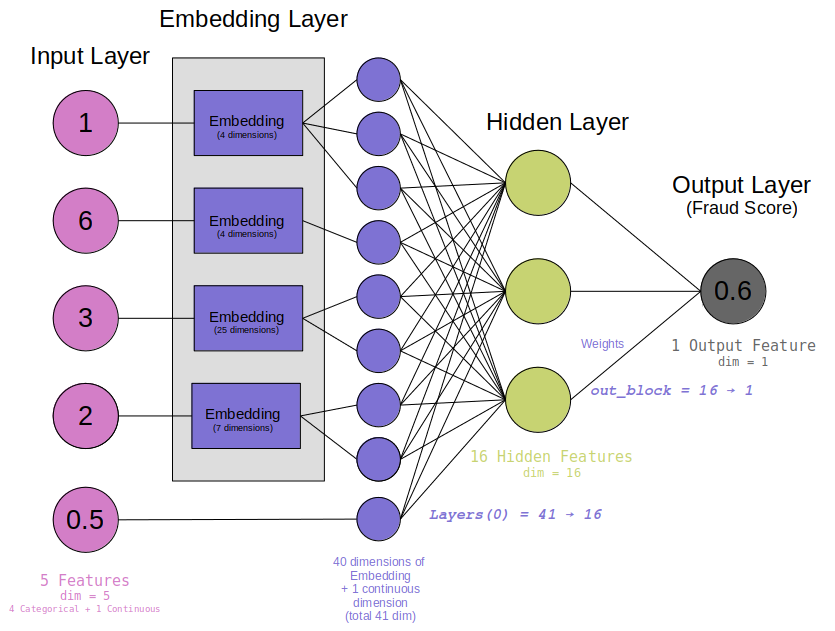

# Start training

### First find a decent Learning Rate. 
> Create a trainer and run the find_lr funtion and plot. This function iterates over the batches, gradually increasing the learning rate from a minimum to a maximum learning rate. It tends to show where we can find a good learning rate.

2021-09-15 15:13:50.676 d373c7.pytorch.training        INFO     Saving model under ./temp_model.pt
Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 375.74it/s]
2021-09-15 15:13:52.802 d373c7.pytorch.training        INFO     Restoring model from ./temp_model.pt


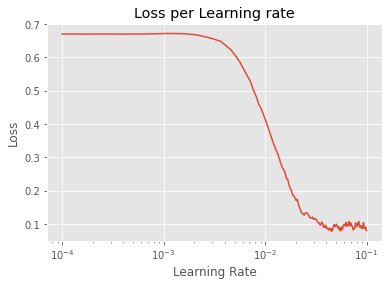

In [9]:
t = pt.Trainer(m, device, train_dl, val_dl)
r = t.find_lr(1e-4, 1e-1, 200)
pl.TrainPlot().plot_lr(r)

## Start Training and plot the results
> We train for __10 epochs__ and __learning rate 5e-3__. We see the model behaves fairly well during training. The loss goes up slightly in the middle of the training. This is the one_cycle logic which is reaching the max learning rate. 

Epoch 010/010: 100%|██████████| 3866/3866 [00:06<00:00, 577.00it/s, train_loss=0.0574, train_acc=0.977, val_loss=0.0379, val_acc=0.981]


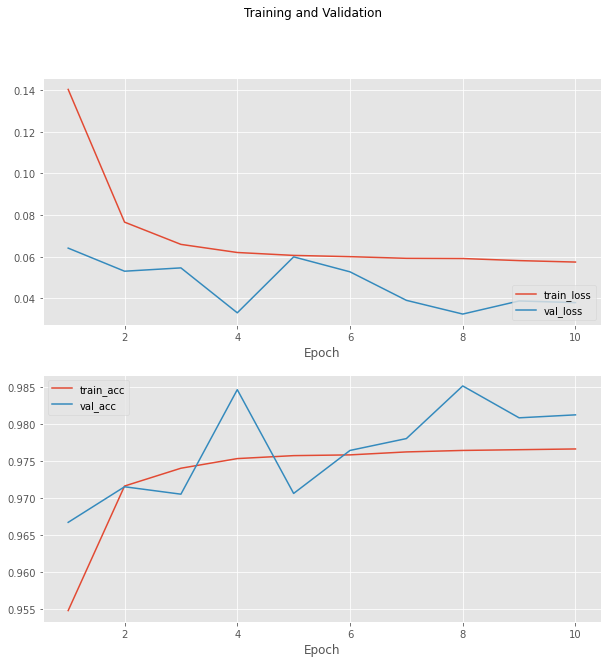

In [10]:
t = pt.Trainer(m, device, train_dl, val_dl)
h = t.train_one_cycle(10, 5e-3)
pl.TrainPlot().plot_history(h, fig_size=(10,10))

## Test the model on the test data
> Test the model on the test set. This model behaves fairly OK and as we expected. Similar results to the training results, this behaves similar to the previous example.

Testing in 782 steps: 100%|██████████| 782/782 [00:00<00:00, 1160.85it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     98926
         1.0       0.40      0.98      0.57      1074

    accuracy                           0.98    100000
   macro avg       0.70      0.98      0.78    100000
weighted avg       0.99      0.98      0.99    100000


auc score : 0.9987
ap score  : 0.9278
-----------------------------------------------------


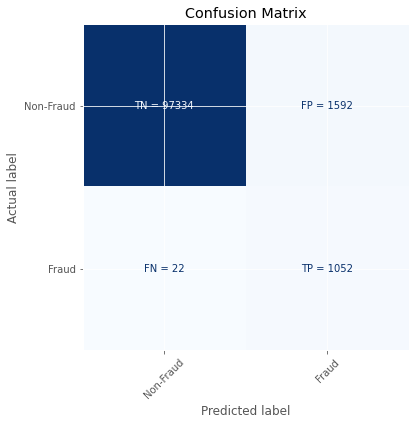

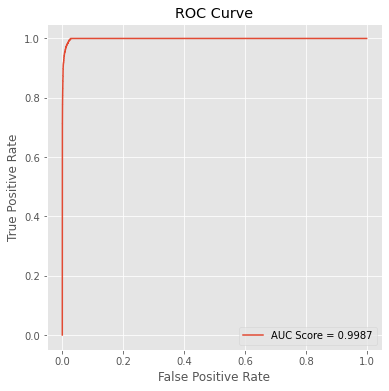

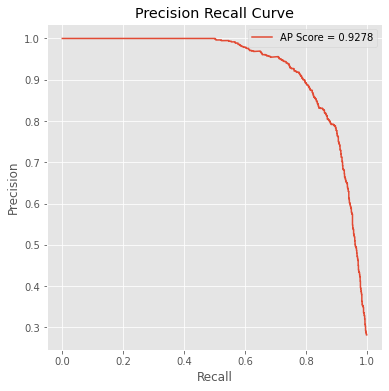

In [11]:
test_ds = pt.NumpyListDataSetMulti(model_features, test_data)
test_dl = test_ds.data_loader(cpu, 128, num_workers=2)

ts = pt.Tester(m, device, test_dl)
pr = ts.test_plot()
tp = pl.TestPlot()
tp.print_classification_report(pr)
tp.plot_confusion_matrix(pr, fig_size=(6,6))
tp.plot_roc_curve(pr, fig_size=(6,6))
tp.plot_precision_recall_curve(pr, fig_size=(6,6))

## Plot Embeddings
> Now that we have a trained model we can plot the embeddings. Embeddings try to capture 'aspects' of the data along certain axis. Like the example in the intro where an axis captured the country to capital relation. We can try to visualize some of those 'aspects'.

### Embedding shape
The shape of the trained embedding for the `FeatureIndex` named __'category_i'__ is 16,7. 
- 16 is the number of different values we have in the category. It is the cardinality of that field (+1 for unknown).
- 7 is the dimensionality of the space (i.e. number of coordinates)

So the embedding is a list of 16 points in a 7-dimensional space.

In [12]:
w = m.embedding_weight(category_i, True)
print(f'The Shape of w is {w.shape}')

The Shape of w is (16, 7)


### Plotting
The dimensions of this 7-dimensional space can be reduced (using PCA) and plotted in 2 and 3 dimensions. These dimensions are some of the 'aspects' of the data. PCA is a technique to reduce the dimensionality into 'components' of a space along the axis where there is most variance in the space.
We can see that an enormous amount of variance is explained by the first component. This is the axis along which the space stretched most, where the model found it has to make the biggest distinction between categories.

Be aware that in the plots, the axis scale is different. The scale of the X axis is much bigger than the Y and Z axis

> Understanding which aspect/property the embedding are capturing is not easy. The model does not say/know what they are. They *might* be showing the likelihood of fraud, the average spend per category, how they are used by age-groups. This is the better guess work, we really only know the model saw fit to plot this way and found it useful in the classification fraud vs. non-fraud

*The fact the es_leisure is so far from the rest of the points is data related. A totally disproportionately high % of the es_leisure transactions are Fraud. Probably an error in the data*

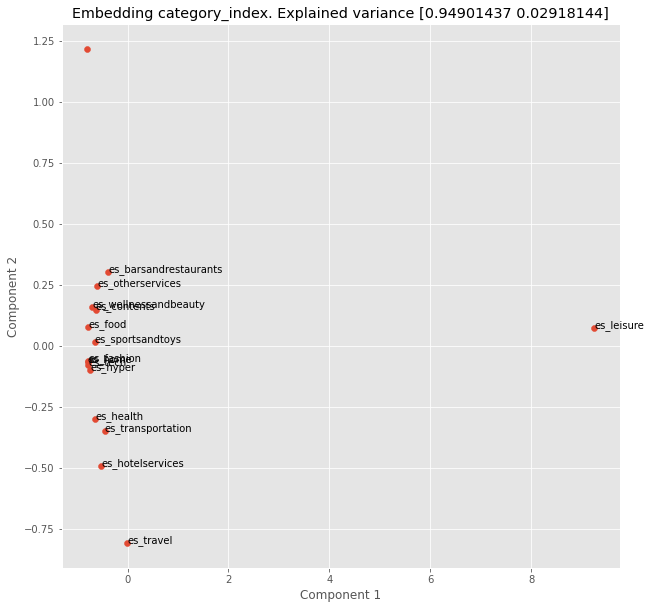

In [13]:
w = m.embedding_weight(category_i, True)
pl.LayerPlot().plot_embedding(category_i, w, fig_size=(10,10))

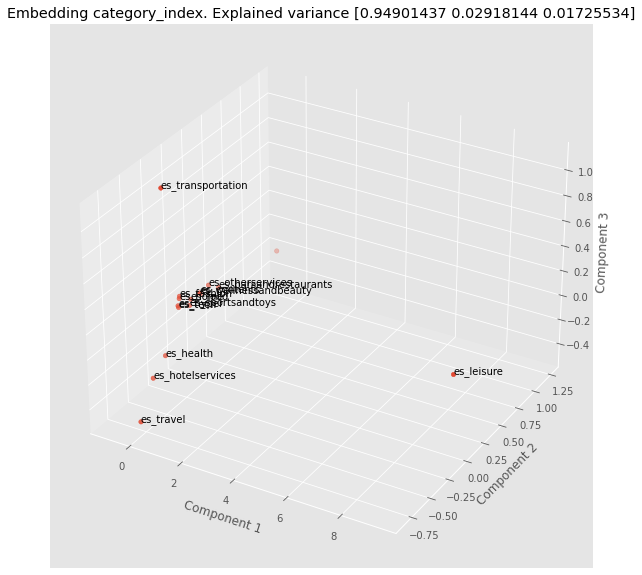

In [14]:
w = m.embedding_weight(category_i, True)
pl.LayerPlot().plot_embedding(category_i, w, dims=3, fig_size=(10,10))

# Conclusion
This notebook showed how embeddings can be used. One might wonder what their use is if they do not get us better results. That is mainly due to the file. 

On bigger more complex dataset in general it is best to set-up categorical fields as embeddings. Converting lots of high cardinality categorical fields to one-hot encoded would result in massively sparse vectors.

Competitions like the Kaggle Grossman show that 'entity embedding' can come very close to models with 'handcrafted' features.